Ref : 텐서플로 2와 머신러닝으로 시작하는 자연어 처리

송영숙님께서 제공한 ChatbotData.csv 파일로 챗봇 모델 제작을 하고 합니다

1. 데이터 구성이 어떠한지 분석 먼저 해보겠습니다.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
!pip install konlpy
from konlpy.tag import Okt
from functools import reduce
from wordcloud import WordCloud

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 8.1MB/s 
     |████████████████████████████████| 460kB 40.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [13]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [14]:
DATA_IN_PATH = 'gdrive/My Drive/RogerHeederer/NLP_KR/6.CHATBOT_heederer/data_in/'

In [15]:
data = pd.read_csv(DATA_IN_PATH + 'ChatBotData.csv', encoding='utf-8')
print(data.head())

                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


##1.문장 전체에 대한 분석##

In [19]:
#데이터의 길이 분석 (질문과 답변을 합쳐서 길이를 분석해보자)
list(data['Q'][0:5])

['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']

In [20]:
list(data['A'][0:5])

['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.', '눈살이 찌푸려지죠.']

In [23]:
sentences = list(data['Q']) + list(data['A'])
sentences[0:5] # Q와 A가 페어로 합쳐지는 것이 아닌, Q 제일 끝에 A가 이어 합쳐진다

['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']

In [24]:
# 음절, 어절, 형태소 -> 3가지 기준으로 나눈 후 길이를 측정해보자
tokenized_sentences = [s.split() for s in sentences]
sent_len_by_token = [len(t) for t in tokenized_sentences] #어절 길이 측정
sent_len_by_eumjeol = [len(s.replace(' ', '')) for s in sentences] #음절 길이 측정

from konlpy.tag import Twitter
okt = Okt()

morph_tokenized_sentences = [okt.morphs(s.replace(' ','')) for s in sentences]
sent_len_by_morph = [len(t) for t in morph_tokenized_sentences] # 형태소 길이 측정

그래프로 각 단위 별 결과값 알아보기

Text(0, 0.5, 'Number of Sentences')

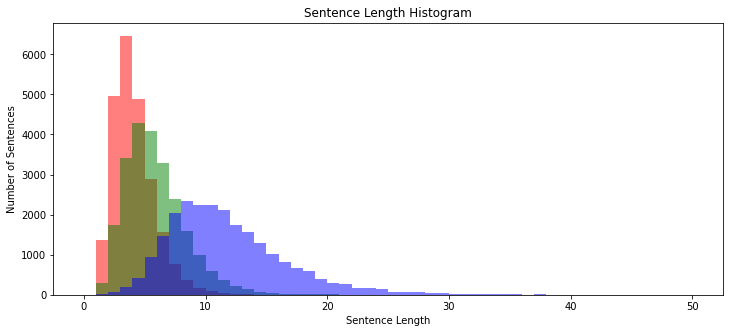

In [26]:
plt.figure(figsize=(12,5))
plt.hist(sent_len_by_token, bins=50, range=[0,50], alpha=0.5, color='r', label='Eojeol')#어절
plt.hist(sent_len_by_morph, bins=50, range=[0,50], alpha=0.5, color='g', label='Morph')#형태소
plt.hist(sent_len_by_eumjeol, bins=50, range=[0,50], alpha=0.5, color='b', label='Eumjeol')#음절

plt.title('Sentence Length Histogram')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')

Y 값의 분포가 어절, 형태소, 음절별로 다르다. 그래서 Y 값의 크기를 조정해서 (스케일 조정) 차이가 큰 데이터에 대해서도 함께 비교 가능하게 해보자

Text(0, 0.5, 'Number of Sentences')

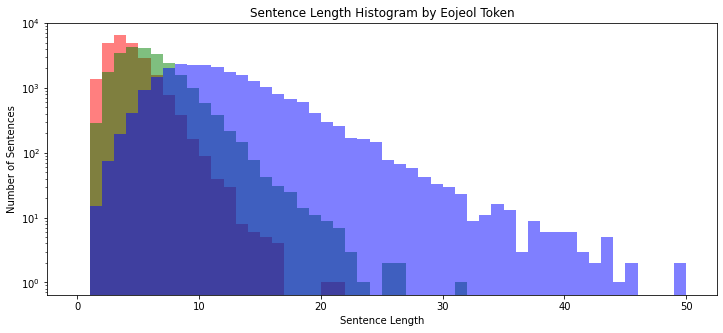

In [27]:

plt.figure(figsize=(12, 5))
plt.hist(sent_len_by_token, bins=50, range=[0,50], alpha=0.5, color= 'r', label='eojeol')
plt.hist(sent_len_by_morph, bins=50, range=[0,50], alpha=0.5, color='g', label='morph')
plt.hist(sent_len_by_eumjeol, bins=50, range=[0,50], alpha=0.5, color='b', label='eumjeol')
# Y scale 추가
plt.yscale('log')
plt.title('Sentence Length Histogram by Eojeol Token')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')

각 단위(어절,형태소,음절)에 대한 통계값을 한번 살펴보자

In [28]:
print('어절 최대길이: {}'.format(np.max(sent_len_by_token)))
print('어절 최소길이: {}'.format(np.min(sent_len_by_token)))
print('어절 평균길이: {:.2f}'.format(np.mean(sent_len_by_token)))
print('어절 길이 표준편차: {:.2f}'.format(np.std(sent_len_by_token)))
print('어절 중간길이: {}'.format(np.median(sent_len_by_token)))
print('제 1 사분위 길이: {}'.format(np.percentile(sent_len_by_token, 25)))
print('제 3 사분위 길이: {}'.format(np.percentile(sent_len_by_token, 75)))

어절 최대길이: 21
어절 최소길이: 1
어절 평균길이: 3.64
어절 길이 표준편차: 1.74
어절 중간길이: 3.0
제 1 사분위 길이: 2.0
제 3 사분위 길이: 5.0


In [29]:
print('형태소 최대길이: {}'.format(np.max(sent_len_by_morph)))
print('형태소 최소길이: {}'.format(np.min(sent_len_by_morph)))
print('형태소 평균길이: {:.2f}'.format(np.mean(sent_len_by_morph)))
print('형태소 길이 표준편차: {:.2f}'.format(np.std(sent_len_by_morph)))
print('형태소 중간길이: {}'.format(np.median(sent_len_by_morph)))
print('형태소 1/4 퍼센타일 길이: {}'.format(np.percentile(sent_len_by_morph, 25)))
print('형태소 3/4 퍼센타일 길이: {}'.format(np.percentile(sent_len_by_morph, 75)))

형태소 최대길이: 31
형태소 최소길이: 1
형태소 평균길이: 5.41
형태소 길이 표준편차: 2.56
형태소 중간길이: 5.0
형태소 1/4 퍼센타일 길이: 4.0
형태소 3/4 퍼센타일 길이: 7.0


In [30]:
print('음절 최대길이: {}'.format(np.max(sent_len_by_eumjeol)))
print('음절 최소길이: {}'.format(np.min(sent_len_by_eumjeol)))
print('음절 평균길이: {:.2f}'.format(np.mean(sent_len_by_eumjeol)))
print('음절 길이 표준편차: {:.2f}'.format(np.std(sent_len_by_eumjeol)))
print('음절 중간길이: {}'.format(np.median(sent_len_by_eumjeol)))
print('음절 1/4 퍼센타일 길이: {}'.format(np.percentile(sent_len_by_eumjeol, 25)))
print('음절 3/4 퍼센타일 길이: {}'.format(np.percentile(sent_len_by_eumjeol, 75)))

음절 최대길이: 57
음절 최소길이: 1
음절 평균길이: 11.31
음절 길이 표준편차: 4.98
음절 중간길이: 10.0
음절 1/4 퍼센타일 길이: 8.0
음절 3/4 퍼센타일 길이: 14.0


위 통계치를 보았을 때, 전체 문자 수(음절단위)는 11개 정도의 평균값을 가지고 있고, 띄어쓰기로 구분한 어절은 3~4개 형태소는 6~7

**박스플롯을 통해 위 수치값의 폭을 살펴보자**

{'boxes': [<matplotlib.lines.Line2D at 0x7f685e400c18>,
 'caps': [<matplotlib.lines.Line2D at 0x7f685e40c668>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f685e416470>,
 'means': [<matplotlib.lines.Line2D at 0x7f685e416128>,
 'medians': [<matplotlib.lines.Line2D at 0x7f685e40cd68>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f685e400f28>,
  <matplotlib.lines.Line2D at 0x7f685e429ba8>]}

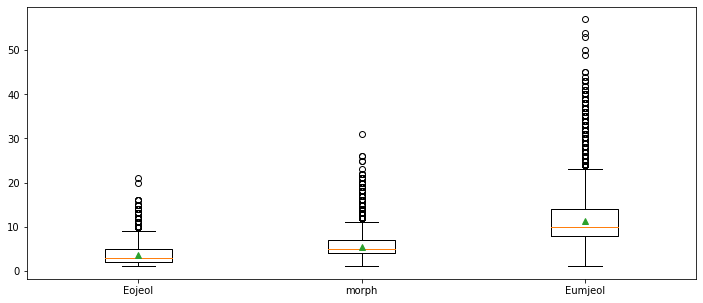

In [32]:
plt.figure(figsize=(12,5))
plt.boxplot([sent_len_by_token, sent_len_by_morph, sent_len_by_eumjeol],
            labels=['Eojeol', 'morph', 'Eumjeol'],
            showmeans=True)

위 박스플롯을 통해 알 수 있는 점은, 대체로 문장의 길이는 5~15 길이를 중심으로 분포해 있으며, 음절의 경우 길이 분포가 어절과 형태소에 비해 훨씬 크다. 그리고 꼬리가 긴 형태로 분포돼 있음을 알 수 있다.

##2. 질문,답변 각각에 대한 문장 길이 분석 ##

형태소 분석(morph)만을 해보겠다

In [34]:
query_sentences = list(data['Q'])
answer_sentences = list(data['A'])

query_morph_tokenized_sentences = [okt.morphs(s.replace(' ', '')) for s in query_sentences]
query_sent_len_by_morph = [len(t) for t in query_morph_tokenized_sentences]

answer_morph_tokenized_sentences = [okt.morphs(s.replace(' ', '')) for s in answer_sentences]
answer_sent_len_by_morph = [len(t) for t in answer_morph_tokenized_sentences]

Text(0, 0.5, 'Number of Queries')

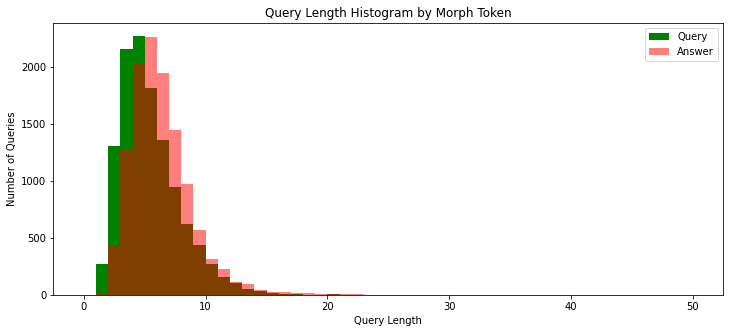

In [35]:
plt.figure(figsize=(12, 5))
plt.hist(query_sent_len_by_morph, bins=50, range=[0,50], color='g', label='Query')
plt.hist(answer_sent_len_by_morph, bins=50, range=[0,50], color='r', alpha=0.5, label='Answer')
plt.legend()
plt.title('Query Length Histogram by Morph Token')
plt.xlabel('Query Length')
plt.ylabel('Number of Queries')

Text(0, 0.5, 'Number of Queries')

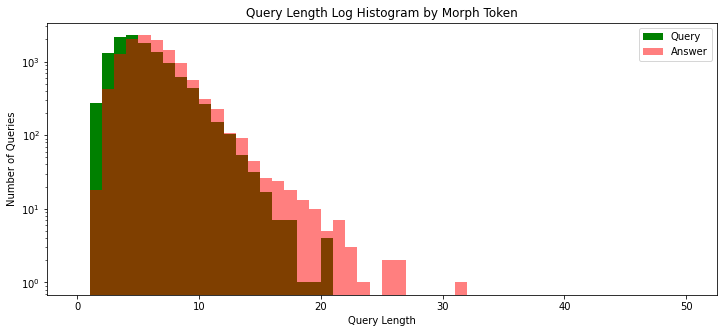

In [36]:
plt.figure(figsize=(12, 5))
plt.hist(query_sent_len_by_morph, bins=50, range=[0,50], color='g', label='Query')
plt.hist(answer_sent_len_by_morph, bins=50, range=[0,50], color='r', alpha=0.5, label='Answer')
plt.legend()
plt.yscale('log', nonposy='clip')
plt.title('Query Length Log Histogram by Morph Token')
plt.xlabel('Query Length')
plt.ylabel('Number of Queries')

히스토그램을 보았을 때 질문 문장 길이가 응답 문장 길이보다 상대적으로 짧다는 것을 확인할 수 있다. 

답변 데이터에 이상치 값이 많은 것을 확인할 수 있다. 

In [37]:
print('형태소 최대길이: {}'.format(np.max(query_sent_len_by_morph)))
print('형태소 최소길이: {}'.format(np.min(query_sent_len_by_morph)))
print('형태소 평균길이: {:.2f}'.format(np.mean(query_sent_len_by_morph)))
print('형태소 길이 표준편차: {:.2f}'.format(np.std(query_sent_len_by_morph)))
print('형태소 중간길이: {}'.format(np.median(query_sent_len_by_morph)))
print('형태소 1/4 퍼센타일 길이: {}'.format(np.percentile(query_sent_len_by_morph, 25)))
print('형태소 3/4 퍼센타일 길이: {}'.format(np.percentile(query_sent_len_by_morph, 75)))

형태소 최대길이: 20
형태소 최소길이: 1
형태소 평균길이: 4.95
형태소 길이 표준편차: 2.48
형태소 중간길이: 4.0
형태소 1/4 퍼센타일 길이: 3.0
형태소 3/4 퍼센타일 길이: 6.0


In [38]:
print('형태소 최대길이: {}'.format(np.max(answer_sent_len_by_morph)))
print('형태소 최소길이: {}'.format(np.min(answer_sent_len_by_morph)))
print('형태소 평균길이: {:.2f}'.format(np.mean(answer_sent_len_by_morph)))
print('형태소 길이 표준편차: {:.2f}'.format(np.std(answer_sent_len_by_morph)))
print('형태소 중간길이: {}'.format(np.median(answer_sent_len_by_morph)))
print('형태소 1/4 퍼센타일 길이: {}'.format(np.percentile(answer_sent_len_by_morph, 25)))
print('형태소 3/4 퍼센타일 길이: {}'.format(np.percentile(answer_sent_len_by_morph, 75)))

형태소 최대길이: 31
형태소 최소길이: 1
형태소 평균길이: 5.87
형태소 길이 표준편차: 2.55
형태소 중간길이: 5.0
형태소 1/4 퍼센타일 길이: 4.0
형태소 3/4 퍼센타일 길이: 7.0


{'boxes': [<matplotlib.lines.Line2D at 0x7f685d4de3c8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f685d4dedd8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f685d4f8898>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f685d4f8518>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f685d4de6d8>,
  <matplotlib.lines.Line2D at 0x7f685d456358>]}

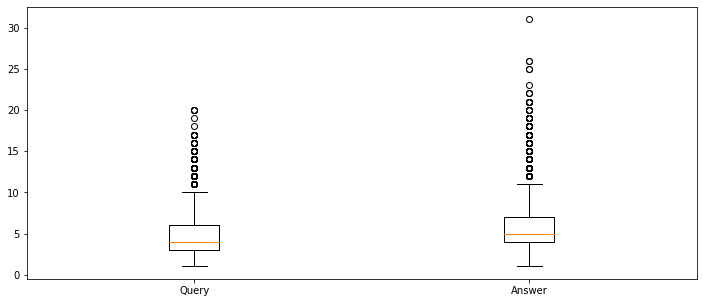

In [39]:
plt.figure(figsize=(12,5))
plt.boxplot([query_sent_len_by_morph, answer_sent_len_by_morph], labels=['Query', 'Answer'])

앞서 히스토그램과 통계값에서는 답변 데이터의 평균 길이가 질문 데이터보다 길었는데, 박스 플롯을 그려보니까 질문 데이터가 더 큰것을 확인할 수 있다. 

이건 답변 데이터의 경우 길이가 긴 이상치 데이터가 많아서 평균값이 더욱 크게 측정되었다는 것을 추론할 수 있다. 

자, 이제 최종 분석값들을 베이스로 문장 길이를 선택해야 하는데, 해당 책에서는 문장 길이 25를 설정한다.

##3.데이터 어휘 빈도 분석##

자주 사용되는 단어를 분석하면 '이', '가', 를' 등의 조사가 가장 큰 빈도수를 차지한다. 이는 별 의미 없으므로, 의미상 중요한 명사 형용사 동사만 따로 모은 후 빈도수 분석을 진행한다 

그러기 위해서는 품사에 따라 구분하는 작업을 먼저 해줘야 한다

In [40]:
okt.pos('오늘밤은유난히덥구나')

[('오늘밤', 'Noun'), ('은', 'Josa'), ('유난히', 'Adverb'), ('덥구나', 'Adjective')]

In [41]:
#명사 형용사 동사를 제외한 단어를 모두 제거하는 문자열을 만들어보자
query_NVA_token_sentences = list()
answer_NVA_token_sentences = list()

for s in query_sentences:
  for token, tag in okt.pos(s.replace(' ', '')):
    if tag == 'Noun' or tag == 'Verb' or tag == 'Adjective':
      query_NVA_token_sentences.append(token)

for s in answer_sentences:
    temp_token_bucket = list()
    for token, tag in okt.pos(s.replace(' ', '')):
        if tag == 'Noun' or tag == 'Verb' or tag == 'Adjective':
            answer_NVA_token_sentences.append(token)
            
query_NVA_token_sentences = ' '.join(query_NVA_token_sentences)
answer_NVA_token_sentences = ' '.join(answer_NVA_token_sentences)

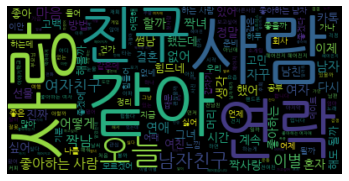

In [42]:
query_wordcloud = WordCloud(font_path = DATA_IN_PATH + 'NanumGothic.ttf').generate(query_NVA_token_sentences)

plt.imshow(query_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

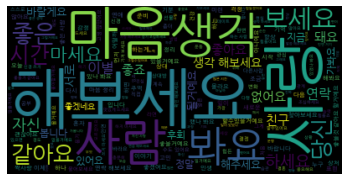

In [43]:
query_wordcloud = WordCloud(font_path= DATA_IN_PATH + 'NanumGothic.ttf').generate(answer_NVA_token_sentences)

plt.imshow(query_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()